# Testing the PILCO framework

In [1]:
# %load ~/dev/marthaler/header.py
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
# Enable Float64 for more stable matrix inversions.
import jax
from jax import Array, config
import jax.numpy as jnp
from jax.tree_util import Partial
import numpy as np
import jax.random as jr
from jaxtyping import ArrayLike, install_import_hook
import matplotlib as mpl
import matplotlib.pyplot as plt

config.update("jax_enable_x64", True)
import gpjax as gpx

key = jr.key(123)

cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

In [3]:
import gymnasium as gym

In [4]:
from controllers import RandomController, Sum_of_Sinusoids
from model_learning.gp_models import MGPR

In [5]:
from flax import nnx
import typing_extensions as tpe
import optax as ox
from gpjax.typing import (
    ScalarFloat,
)
from typing import Tuple

In [6]:
from IPython import display

# Functions

In [7]:
def cart_pole_cost(
    states_sequence: ArrayLike, 
    target_state: ArrayLike = jnp.array([jnp.pi,0.0]), 
    lengthscales: ArrayLike = jnp.array([3.0,1.0]),
    angle_index:int = 2,
    pos_index:int = 0
)->Array:
    """
    Cost function given by the combination of the saturated distance between |theta| and 'target angle', and between x and 'target position'.
    """
    x = states_sequence[pos_index]
    theta = states_sequence[angle_index]

    target_x = target_state[1]
    target_theta = target_state[0]

    return 1 - jnp.exp(
        -(jnp.square((jnp.abs(theta) - target_theta) / lengthscales[0])) - jnp.square((x - target_x) / lengthscales[1])
    )

## Globals

In [8]:
num_particles = 400

In [9]:
num_trials = 5
T_sampling = 0.05
T_exploration = 3.0
T_control = 3.0
sim_timestep = 0.01

## Generate the environments

In [10]:
env = gym.make("InvertedPendulum-v5")
env_test = gym.make("InvertedPendulum-v5", render_mode='rgb_array')

DependencyNotInstalled: MuJoCo is not installed, run `pip install "gymnasium[mujoco]"`

In [11]:
action_dim = env.action_space.shape[0]
x, _ = env.reset()
state_dim = x.shape[0]
num_basis = 200
umax = 3.0
policy = Sum_of_Sinusoids(state_dim, action_dim, num_basis, -jnp.pi, jnp.pi, -1.0, 1.0, True, umax)

In [12]:
# Initialize a random controller
exploration_policy = RandomController(state_dim,action_dim,True,3.0)

In [13]:
# Randomly sample some points
key = jr.key(42)
x, _ = env.reset()
states = [x]
key, subkey = jr.split(key)
u = exploration_policy(x,0,subkey)
actions = [u]

for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
    z = env.step(np.array(u))
    x = z[0]
    states.append(x)
    key, subkey = jr.split(key)
    u = exploration_policy(x,timestep,subkey)
    actions.append(u)

In [14]:
model = MGPR(states=jnp.array(states),actions=jnp.array(actions))

In [15]:
# Should vmap the optimization
model.optimize()

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/daniel.marthaler/.pyenv/versions/pilco/lib/python3.11/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
/Users/daniel.marthaler/.pyenv/versions/pilco/lib/python3.11/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
# Now do a rollout with this model
# Generate an initial state
x, _ = env.reset()
key, subkey = jr.split(key)
# Generate an initial (action
u = exploration_policy(x,timestep,subkey)

In [17]:
test_inputs = model.data_to_gp_input(states, actions)

In [18]:
predictive_means = []
predictive_stds = []
for i in range(model.num_outputs):
    latent_dist = model.models[i].predict(
        test_inputs,
        train_data=gpx.Dataset(
            X=model.data.X, y=model.data.y[:, i].reshape(-1, 1)
        ),
    )
    predictive_dist = model.models[i].likelihood(latent_dist)

    predictive_means.append(predictive_dist.mean())
    predictive_stds.append(predictive_dist.stddev())
predictive_moments = jnp.stack(
    (
        jnp.array(predictive_means).T + test_inputs[:, : model.num_outputs],
        jnp.array(predictive_stds).T,
    ),
    axis=2,
)


/Users/daniel.marthaler/.pyenv/versions/pilco/lib/python3.11/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [17]:
# initialize some particles
initial_particles = model.get_samples(key, jnp.array([x]), jnp.array([u]), num_particles)

/Users/daniel.marthaler/.pyenv/versions/pilco/lib/python3.11/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [19]:
def one_rollout_step(carry, t):
    graphdef, params, get_samples, key, samples, total_cost = carry
    compute_action = nnx.merge(graphdef, params)
    actions = jax.vmap(compute_action)(samples,jnp.tile(t,num_particles))

    key, subkey = jr.split(key)
    samples = get_samples(key, samples, actions, 1)
    cost = jnp.sum(jax.vmap(cart_pole_cost)(jnp.hstack((samples, actions))))
    return (graphdef, params,get_samples,key,samples,total_cost+cost), cost

def rollout(
    params: nnx.statelib.State,
    graphdef: nnx.graph.NodeDef,
    init_samples: ArrayLike,
    model: nnx.Module,
    timesteps: ArrayLike,
    key = jr.key(123),
)->ScalarFloat:
    get_samples = Partial(model.get_samples)
    total_cost = 0
    (graphdef, params,get_samples,key,samples,total_cost), result = jax.lax.scan(
        one_rollout_step, (graphdef, params,get_samples,key,init_samples,total_cost), timesteps
    )
    return total_cost/len(timesteps)

In [21]:
control_horizon = int(T_control/T_sampling)

In [22]:
objective_fun = Partial(rollout,init_samples=initial_particles,model=model,timesteps=jnp.arange(control_horizon))

In [23]:
def fit_controller(  # noqa: PLR0913
    *,
    policy: nnx.Module,
    objective: tpe.Callable[[nnx.Module,None],ScalarFloat],
    optim: ox.GradientTransformation,
    key: ArrayLike = jr.PRNGKey(42),
    num_iters: int = 100,
    unroll: int = 5,
)->Tuple[nnx.Module,Array]:
    
    graphdef, params = nnx.split(policy)
    
    def loss(params: nnx.State):
        return objective(params,graphdef)
    
    opt_state = optim.init(params)
    
    # Mini-batch random keys to scan over.
    iter_keys = jr.split(key, num_iters)
    
    # Optimisation step.
    @jax.jit
    def step(carry, key):
        params, opt_state = carry
    
        loss_val, loss_gradient = jax.value_and_grad(loss)(params)
        updates, opt_state = optim.update(loss_gradient, opt_state, params, value=loss_val, grad=loss_gradient,value_fn=loss)
        params = ox.apply_updates(params, updates)
    
        carry = params, opt_state
        return carry, loss_val
    
    # Optimisation loop.
    (params, _), history = jax.lax.scan(step, (params, opt_state), (iter_keys), unroll=unroll)
    
    # Reconstruct model
    return_policy = nnx.merge(graphdef, params)
    return return_policy, history

In [24]:
optimizer = ox.adam(learning_rate=1e-3)

In [26]:
%%time
op, hist = fit_controller(policy = policy, objective = objective_fun, optim=optimizer, num_iters=100)

CPU times: user 17min 18s, sys: 1min 18s, total: 18min 37s
Wall time: 5min 22s


In [27]:
%%time
op, hist = fit_controller(policy = policy, objective = objective_fun, optim=optimizer, num_iters=1000)

CPU times: user 2h 52min 19s, sys: 13min 45s, total: 3h 6min 5s
Wall time: 52min 48s


In [28]:
%%time
op, hist = fit_controller(policy = policy, objective = objective_fun, optim=optimizer, num_iters=10000)

CPU times: user 1d 4h 40min 58s, sys: 2h 2min 24s, total: 1d 6h 43min 23s
Wall time: 8h 36min


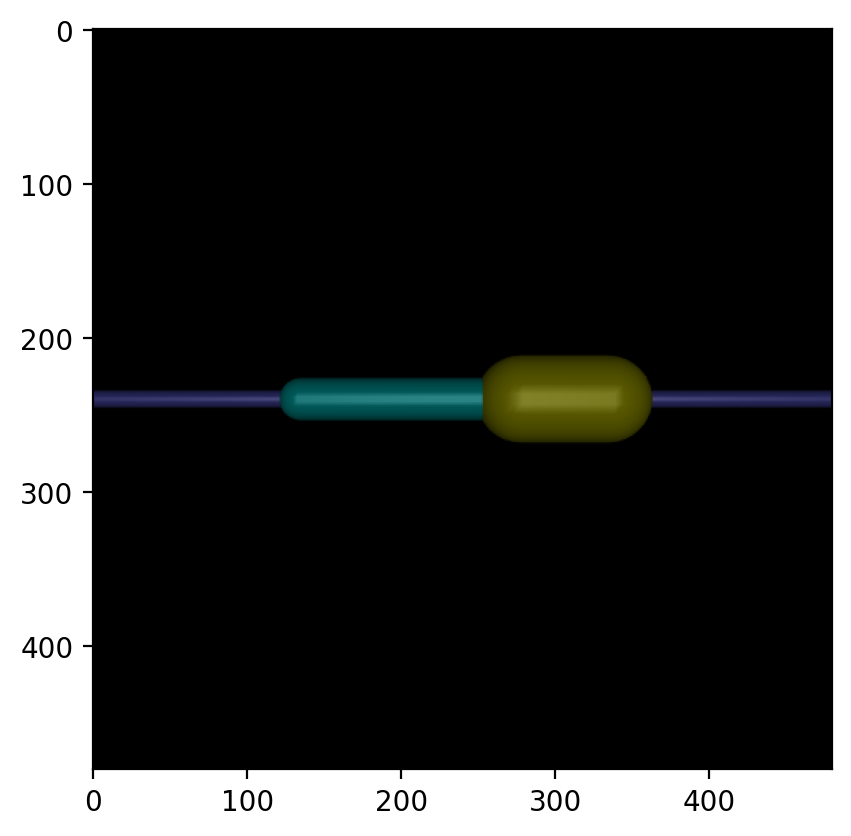

In [28]:
# Now try this policy on the real system
x, _ = env_test.reset()
key, subkey = jr.split(key)
u = policy(x,timestep,subkey)
# Randomly sample some points
states.append(x)
actions.append(u)
img = plt.imshow(env_test.render()) # only call this once
for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
    z = env_test.step(np.array(u))
    x = z[0]
    r = z[1]
    key, subkey = jr.split(key)
    u = policy(x,timestep,subkey)
    states.append(x)
    actions.append(u)
    img.set_data(env_test.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [29]:
model = DynamicalModel(states=jnp.array(states),actions=jnp.array(actions))
model.optimize()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [31]:
len(states)

606

In [32]:
# Now do a rollout with this model
# Generate an initial state
x, _ = env.reset()
key, subkey = jr.split(key)
# Generate an initial (action
u = exploration_policy(x,timestep,subkey)

In [33]:
initial_particles = model.get_samples(key, jnp.array([x]), jnp.array([u]), num_particles)

In [34]:
objective_fun = Partial(rollout,init_samples=initial_particles,model=model,timesteps=timesteps)

In [35]:
%%time
policy,history = fit_controller(policy=policy,objective=objective_fun,optim=optimizer,num_iters=100)

CPU times: user 2min 10s, sys: 14 s, total: 2min 24s
Wall time: 1min 33s


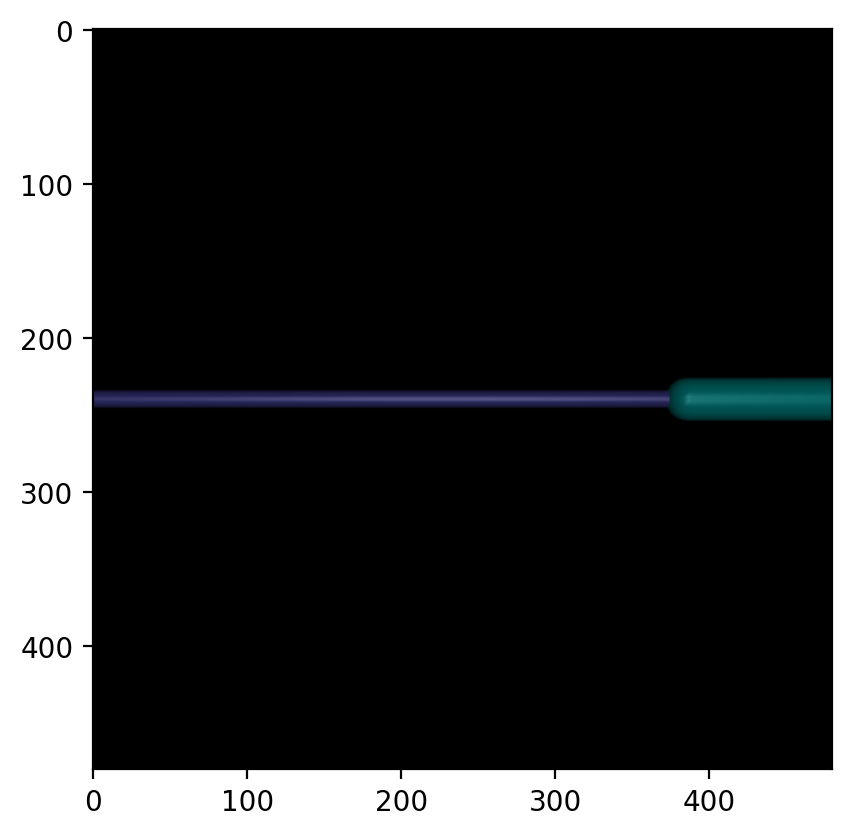

In [36]:
# Now try this policy on the real system
x, _ = env_test.reset()
key, subkey = jr.split(key)
u = policy(x,timestep,subkey)
# Randomly sample some points
states.append(x)
actions.append(u)
img = plt.imshow(env_test.render()) # only call this once
for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
    z = env_test.step(np.array(u))
    x = z[0]
    r = z[1]
    key, subkey = jr.split(key)
    u = policy(x,timestep,subkey)
    states.append(x)
    actions.append(u)
    img.set_data(env_test.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [39]:
model = DynamicalModel(states=jnp.array(states),actions=jnp.array(actions))
model.optimize()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [40]:
# Now do a rollout with this model
# Generate an initial state
x, _ = env.reset()
key, subkey = jr.split(key)
# Generate an initial (action
u = exploration_policy(x,timestep,subkey)

In [41]:
initial_particles = model.get_samples(key, jnp.array([x]), jnp.array([u]), num_particles)

In [42]:
objective_fun = Partial(rollout,init_samples=initial_particles,model=model,timesteps=timesteps)

In [43]:
%%time
policy,history = fit_controller(policy=policy,objective=objective_fun,optim=optimizer,num_iters=100)

CPU times: user 3min 26s, sys: 20 s, total: 3min 46s
Wall time: 2min 28s


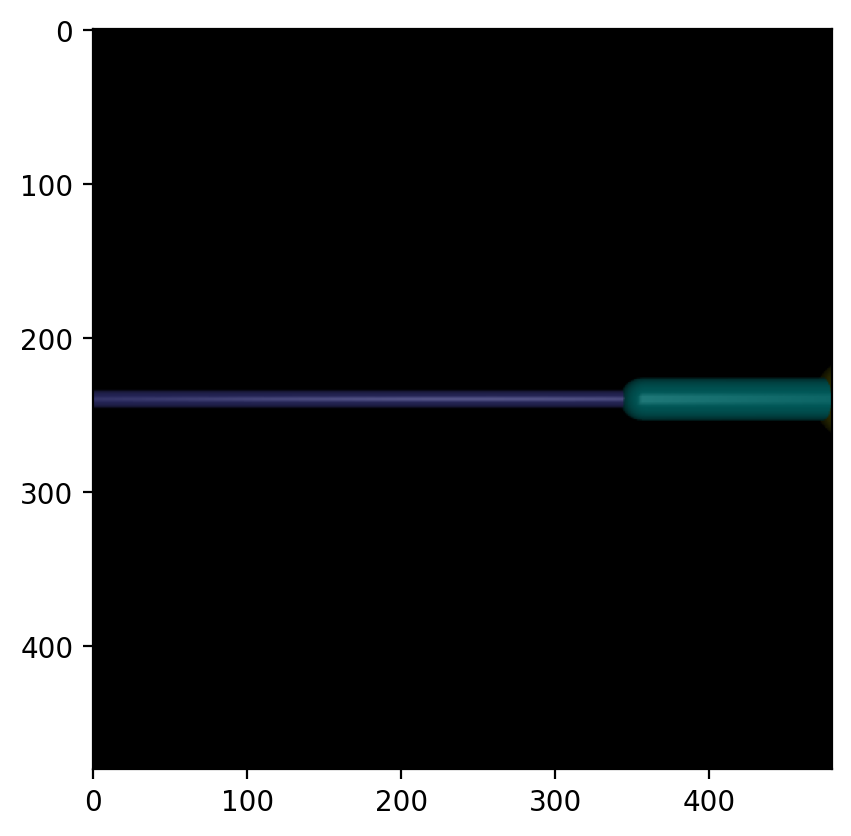

In [45]:
# Now try this policy on the real system
x, _ = env_test.reset()
key, subkey = jr.split(key)
u = policy(x,timestep,subkey)
# Randomly sample some points
states.append(x)
actions.append(u)
img = plt.imshow(env_test.render()) # only call this once
for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
    z = env_test.step(np.array(u))
    x = z[0]
    r = z[1]
    key, subkey = jr.split(key)
    u = policy(x,timestep,subkey)
    states.append(x)
    actions.append(u)
    img.set_data(env_test.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [48]:
import random
import string

def generate_random_string(length):
    characters = string.ascii_letters + string.digits
    return ''.join(random.choice(characters) for i in range(length))

random_string = generate_random_string(100)
print(random_string)

It01hSlVj40SnZLMTTIgZo46LwxLCVg7w28u7y0iquLeqvI6WEKApkgBfBgHk3BeZodKUnUFG9qoldAZbR3NZ4iREGfJrytkgmSr


In [49]:
random_string[-80:]

'Zo46LwxLCVg7w28u7y0iquLeqvI6WEKApkgBfBgHk3BeZodKUnUFG9qoldAZbR3NZ4iREGfJrytkgmSr'